In [1]:
import numpy as np 
import pandas as pd 

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.layers import Input, UpSampling2D, BatchNormalization
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K
from keras.applications.resnet50 import ResNet50,preprocess_input

In [4]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

import numpy as np
import pandas as pd
import os
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label
from skimage.util import crop
from skimage.transform import resize
from skimage.segmentation import find_boundaries, mark_boundaries
from scipy.ndimage.morphology import binary_erosion as erosion
from scipy.ndimage.morphology import binary_dilation as dilation
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train_path = 'train_color_full'
label_path = 'train_label_full'

In [6]:
def get_data():
    label = os.listdir(label_path)
    label.sort()
    train = os.listdir(train_path)
    train.sort()
    df_id = pd.DataFrame()
    df_id['label'] = label
    df_id['train'] = train
    df_id['label_path'] = df_id['label'].apply(lambda x: os.path.join(label_path, x))
    df_id['train_path'] = df_id['train'].apply(lambda x: os.path.join(train_path, x))
    return df_id

df_id = get_data()

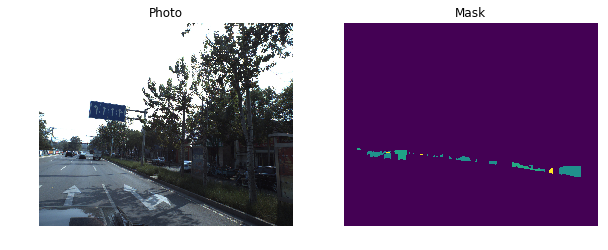

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39222 entries, 0 to 39221
Data columns (total 4 columns):
label         39222 non-null object
train         39222 non-null object
label_path    39222 non-null object
train_path    39222 non-null object
dtypes: object(4)
memory usage: 1.2+ MB
None


,label,train,label_path,train_path
0,170908_061502408_Camera_5_instanceIds.png,170908_061502408_Camera_5.jpg,train_label_full/170908_061502408_Camera_5_ins...,train_color_full/170908_061502408_Camera_5.jpg
1,170908_061502408_Camera_6_instanceIds.png,170908_061502408_Camera_6.jpg,train_label_full/170908_061502408_Camera_6_ins...,train_color_full/170908_061502408_Camera_6.jpg
2,170908_061502547_Camera_5_instanceIds.png,170908_061502547_Camera_5.jpg,train_label_full/170908_061502547_Camera_5_ins...,train_color_full/170908_061502547_Camera_5.jpg
3,170908_061502547_Camera_6_instanceIds.png,170908_061502547_Camera_6.jpg,train_label_full/170908_061502547_Camera_6_ins...,train_color_full/170908_061502547_Camera_6.jpg
4,170908_061502686_Camera_5_instanceIds.png,170908_061502686_Camera_5.jpg,train_label_full/170908_061502686_Camera_5_ins...,train_color_full/170908_061502686_Camera_5.jpg


In [7]:
#show a sample image
ix = np.random.randint(0, len(df_id.index))
train_ex = imread(df_id.loc[ix, 'train_path'])
label_ex = imread(df_id.loc[ix, 'label_path'])
f, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(train_ex)
ax[1].imshow(np.squeeze(label_ex))
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Photo')
ax[1].set_title('Mask')
plt.show()
print(df_id.info())
df_id.head()

In [8]:
from sklearn.model_selection import train_test_split
#split train and validation
df_id_train, df_id_valid = train_test_split(df_id, random_state = 2018, test_size = 0.25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 2 columns):
test         1917 non-null object
test_path    1917 non-null object
dtypes: object(2)
memory usage: 30.0+ KB
None


,test,test_path
0,001bbdb5c4f43bd4dc2b3e3a08b7202a.jpg,test_full/001bbdb5c4f43bd4dc2b3e3a08b7202a.jpg
1,00457f3fa7e5ae64cdeeca1903b58640.jpg,test_full/00457f3fa7e5ae64cdeeca1903b58640.jpg
2,00474e4eeba7484a666283ee56fc29e9.jpg,test_full/00474e4eeba7484a666283ee56fc29e9.jpg
3,008010ef220d33763925e76f9690d1d2.jpg,test_full/008010ef220d33763925e76f9690d1d2.jpg
4,0092bd2ac3c2be679c27811ecb33990e.jpg,test_full/0092bd2ac3c2be679c27811ecb33990e.jpg


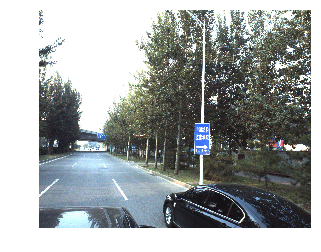

In [9]:
test_path = 'test_full'
def get_test_data():
    test = os.listdir(test_path)
    test.sort()
    df_id = pd.DataFrame()
    df_id['test'] = test
    df_id['test_path'] = df_id['test'].apply(lambda x: os.path.join(test_path, x))
    return df_id

df_test_id = get_test_data()
plt.imshow(imread(df_test_id.sample(n = 1)['test_path'].values[0]))
plt.axis('off')
print(df_test_id.info())
df_test_id.head()

In [14]:
#label classes
target_classes = {33:'car', 34:'motorbicycle', 35:'bicycle', 36:'person', 38:'truck', 39:'bus', 40:'tricycle'}

In [22]:
datagen_arg = dict(horizontal_flip = True)

maskgen_arg = dict(horizontal_flip = True)

x_gen = ImageDataGenerator(**datagen_arg)
mask_gen = ImageDataGenerator(**maskgen_arg)

#creating thicker boundaries in labels
def label_to_mask(y, classes):
    mask_core = np.zeros((y.shape[0], y.shape[1], len(classes)))
    mask_edge = np.zeros((y.shape[0], y.shape[1], 1))
    foreground = (y*((y >= classes[0]*1000) & (y < (classes[-1]+1)*1000))).astype(np.uint16)
    unique_objects = np.delete(np.unique(foreground), 0)
    # mask core
    for i, class_ in enumerate(classes):
        mask_core[:,:,i] = np.squeeze(((foreground/1000).astype(np.int32) == class_).astype(np.bool))
    # This operation makes the edge ~2 pixels thick,
    # remember to fill the pixels back in post processing
    mask_edge = find_boundaries(foreground, mode = 'outer').astype(np.bool)
    return mask_core, mask_edge

def resize_random_crop(images, random_state, resize_w = 1280, resize_h = 720, crop_w = 224, crop_h = 224):
    np.random.seed(random_state)
    # function to shrink and random crop input to desired size for training
   
    images = np.array([resize(image, (resize_h, resize_w), mode = 'constant', preserve_range = True) for image in images])
    height = images.shape[1]
    width = images.shape[2]
    # The randn function is to prevent data augmentation from producing too many crop with sky only
    rand_h_start = (np.clip(0.9*np.random.randn()+0.7, 0, 1)*(height - crop_h)).astype(np.uint16)
    rand_w_start = np.random.randint(0, (width - crop_w))
    return crop(images, ((0, 0), (rand_h_start, height - (rand_h_start + crop_h)),
                        (rand_w_start, width - (rand_w_start + crop_w)), (0, 0)))

def augmentation_checker(mask, classes, percentage = 0.005):
    # function to ensure that the cropped input has at least some mask in it
    mask_core, mask_edge = label_to_mask(mask, classes)
    while np.mean(mask_core) < percentage:
        mask_core, mask_edge = label_to_mask(mask, classes)
    return mask_core, mask_edge

def data_generator(x_gen_, mask_gen_, df_data, mini_bat_size, classes = sorted(target_classes.keys())):
    while True:
        seed = np.random.randint(0,1000)
        sampled_set = df_data.sample(n = mini_bat_size)
        sampled_train = sampled_set['train_path']
        sampled_label = sampled_set['label_path']
        X = preprocess_input(np.array([imread(train_path) for train_path in sampled_train]).astype(np.float32))
        y = np.expand_dims(np.array([imread(label_path) for label_path in sampled_label]), axis = -1)

        x_generator = x_gen_.flow(X, batch_size = mini_bat_size, seed = seed)
        mask_generator = mask_gen_.flow(y, batch_size = mini_bat_size, seed = seed)
        X = resize_random_crop(x_generator.next(), seed)
        y = resize_random_crop(mask_generator.next(), seed)
        y_mask = []
        y_edge = []
        for mask in y:
            mask_core, mask_edge = label_to_mask(mask, classes)
            y_mask.append(mask_core)
            y_edge.append(mask_edge)
        yield (X, {'masks': np.array(y_mask), 'edges': np.array(y_edge)})

In [25]:
mini_bat_size = 20
X, y= next(data_generator(x_gen, mask_gen, df_id, mini_bat_size))

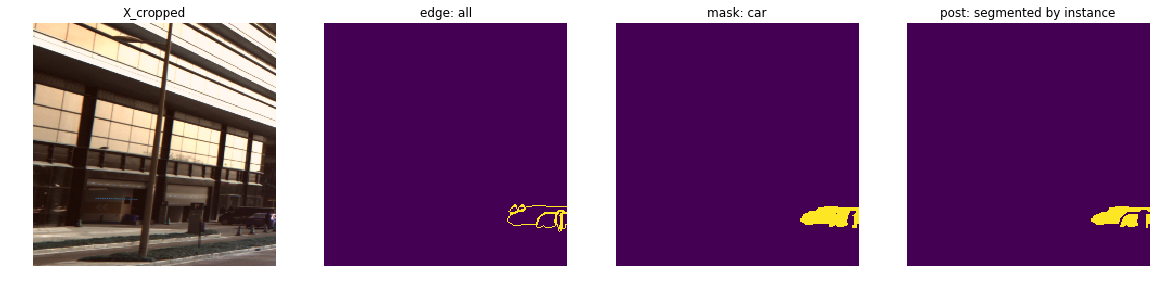

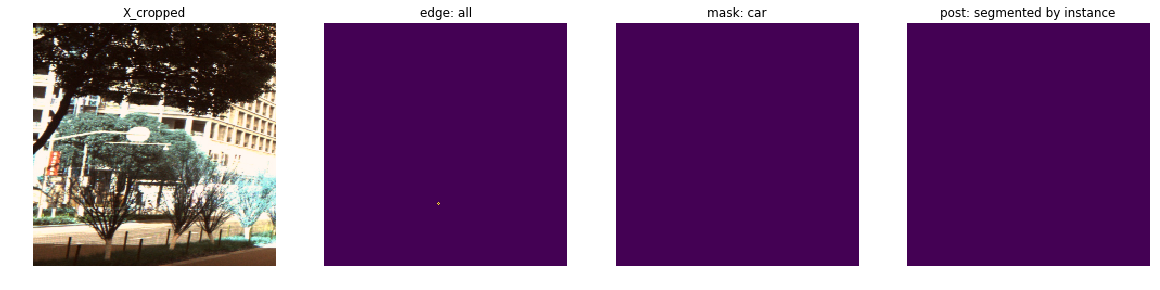

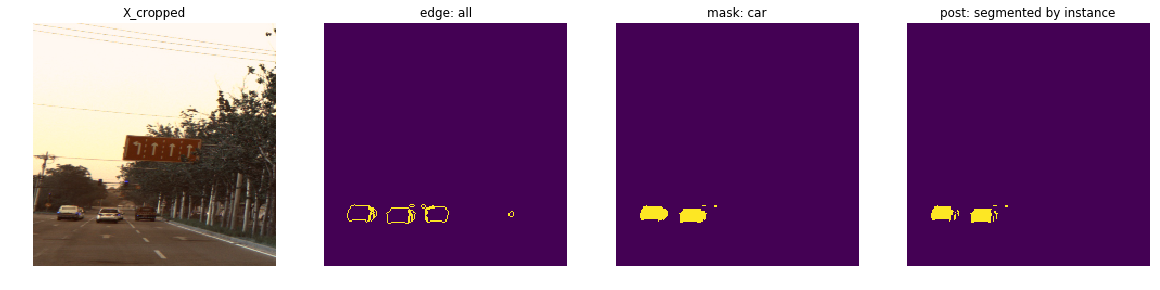

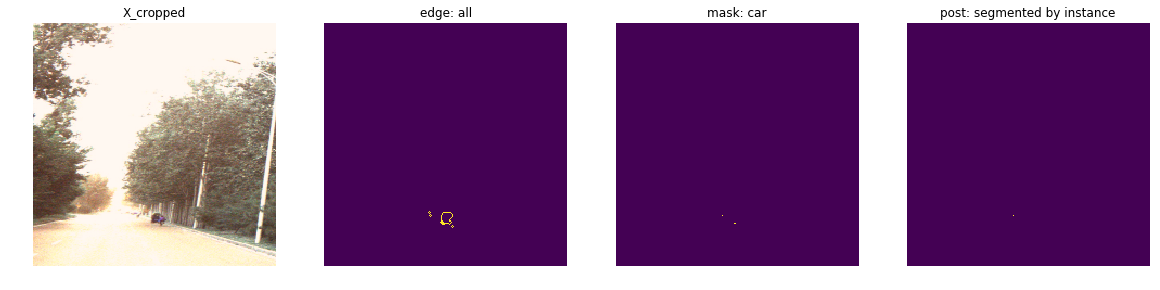

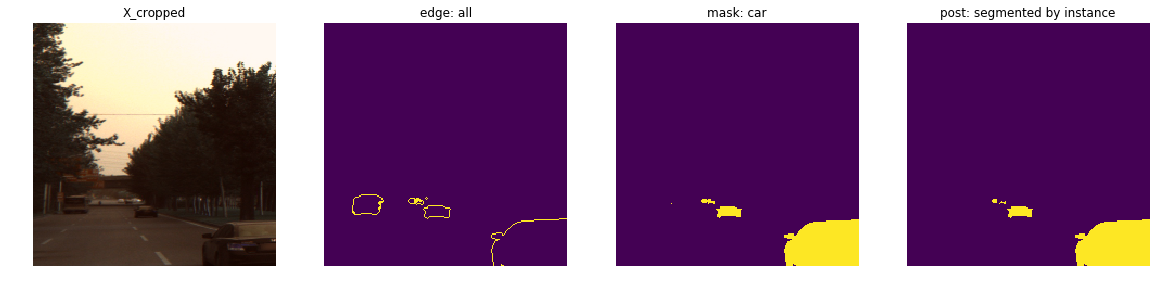

In [26]:
#displaying only cars in the below images
for ix in range(5):
    X_cropped = X[ix]
    y_edge_cropped = np.squeeze(y['edges'][ix])
    y_mask_cropped = np.squeeze(y['masks'][ix,:,:,0])
    y_mask_seg = y_mask_cropped - y_edge_cropped
    f, ax = plt.subplots(1,4, figsize = (20,20))
    r_rgb_img = np.clip(X_cropped+110, 0, 255).astype(np.uint8)
    ax[0].imshow(r_rgb_img) # This is my lazy work to roughly undo preprocessing for this visualization
    ax[0].axis('off')
    ax[0].set_title('X_cropped')
    ax[1].imshow(y_edge_cropped)
    ax[1].axis('off')
    ax[1].set_title('edge: all')
    ax[2].imshow(y_mask_cropped)
    ax[2].axis('off')
    ax[2].set_title('mask: car')
    ax[3].imshow(y_mask_seg > 0)
    ax[3].axis('off')
    ax[3].set_title('post: segmented by instance')

In [20]:
R50 = ResNet50(include_top = False, weights = None, input_shape = (224, 224, 3))
#R50 = ResNet50(weights='weight_path',include_top = False, input_shape = (224, 224, 3))
# pop off the last pooling layer
R50.layers.pop()
for layer in R50.layers:
    layer.trainable = True
    
# Layers from ResNet50 to make skip connections
skip_ix = [172, 140, 78, 36, 3]
# Layers in decoder to connect to encoder
skip_end = []
for i in skip_ix:
    skip_end.append(R50.layers[i])
R50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/home/shared/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [21]:
# Use billinear additive upsampling (BAU) and separable convolution to reduce the total amount of hyperparameters
def BAU_layer(last_layer, channel_num):
    additive = []
    depth = int(last_layer.get_shape()[-1])
    step = int(depth / channel_num)
    last_layer[:, :, :, 1*step:(1*step+step)]
    for i in range(channel_num):
        layersum = K.mean(last_layer[:, :, :, i*step:(i*step+step)], axis = -1)
        additive.append(layersum)
    additive = K.stack(additive, axis = -1)
    return additive

def upsampling_step(skipped_conv, num_output_filters, prev_conv = None):
    num_filters = skipped_conv.output_shape[-1]
    if prev_conv != None:
        concat_layer = concatenate([skipped_conv.output, prev_conv])
    else:
        concat_layer = skipped_conv.output
    conv1 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(concat_layer)
    conv2 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(conv1)
    up = UpSampling2D()(conv2)
    BAU = Lambda(BAU_layer, arguments = {'channel_num': num_output_filters})(up)
    conv3 = SeparableConv2D(num_output_filters, 2, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(BAU)
    return conv3

def output(feature_map, mask = True):
    if mask:
        conv3 = Conv2D(7, 1, padding = 'same', activation = 'sigmoid', kernel_initializer = 'he_normal', name = 'masks')(feature_map)
    else:
        conv3 = Conv2D(1, 1, padding = 'same', activation = 'sigmoid', kernel_initializer = 'he_normal', name = 'edges')(feature_map)
    return conv3

In [27]:
up_num_filters = [1024, 512, 256, 64, 64]
for n, i in enumerate(up_num_filters):
    if n == 0:
        conv_layer = upsampling_step(skip_end[n], i)
    else:
        conv_layer = upsampling_step(skip_end[n], i, conv_layer)
conv1 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(conv_layer)
conv2 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(conv1)

masks = output(conv2)
edges = output(conv2, False)
model = Model(inputs = R50.inputs, outputs = [masks, edges])
model.compile(optimizer = 'adam', loss = {'masks': 'binary_crossentropy', 'edges': 'binary_crossentropy'})

#we keep a low batch-size to reduce runtime
bat_size = 2
result = model.fit_generator(data_generator(x_gen, mask_gen, df_id_train, bat_size), steps_per_epoch = bat_size, epochs = 50,
                            verbose = 1)

Epoch 1/50
2/2 [==============================] - 95s 48s/step - loss: 1.3753 - masks_loss: 0.6930 - edges_loss: 0.6823
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: 1.3343 - masks_loss: 0.6894 - edges_loss: 0.6450
Epoch 3/50
2/2 [==============================] - 2s 1s/step - loss: 1.2585 - masks_loss: 0.6817 - edges_loss: 0.5768
Epoch 4/50
2/2 [==============================] - 2s 1s/step - loss: 1.1214 - masks_loss: 0.6649 - edges_loss: 0.4565
Epoch 5/50
2/2 [==============================] - 2s 1s/step - loss: 0.9092 - masks_loss: 0.6321 - edges_loss: 0.2771
Epoch 6/50
2/2 [==============================] - 2s 1s/step - loss: 0.7093 - masks_loss: 0.5759 - edges_loss: 0.1335
Epoch 7/50
2/2 [==============================] - 2s 1s/step - loss: 0.5201 - masks_loss: 0.4749 - edges_loss: 0.0452
Epoch 8/50
2/2 [==============================] - 2s 1s/step - loss: 0.3737 - masks_loss: 0.3381 - edges_loss: 0.0356
Epoch 9/50
2/2 [==============================] - 2s 1

In [28]:
eval_out =  model.evaluate_generator(data_generator(x_gen, mask_gen, df_id_valid, bat_size), steps=4)
#printing the total loss
print('Loss: %2.2f' % (eval_out[0]))

Loss: 0.31
